In [46]:
# ============================================================
# Block A: Exact Robust Max-Group Loss via CVXPY
# ============================================================

import numpy as np

try:
    import cvxpy as cp
except ImportError as e:
    cp = None
    print("[CVX] cvxpy is not installed. Install with `pip install cvxpy` to enable exact solver.")

def solve_max_group_loss_cvxpy(A_groups, b_groups, verbose=False, solver=None):
    """
    Solve:
        minimize_x max_i (1/n_i) ||A_i x - b_i||^2

    via epigraph form:
        minimize_{x,t} t
        s.t. (1/n_i) ||A_i x - b_i||^2 <= t  for all i.

    Returns:
        x_star (np.ndarray), t_star (float)

    Raises RuntimeError if cvxpy is unavailable or solve fails.
    """
    if cp is None:
        raise RuntimeError("cvxpy not available; cannot solve exact robust problem.")

    m = len(A_groups)
    d = A_groups[0].shape[1]

    x = cp.Variable(d)
    t = cp.Variable()

    constraints = []
    for A_i, b_i in zip(A_groups, b_groups):
        n_i = A_i.shape[0]
        r_i = A_i @ x - b_i
        constraints.append((1.0 / n_i) * cp.sum_squares(r_i) <= t)

    prob = cp.Problem(cp.Minimize(t), constraints)

    # Default solver choice: let cvxpy pick unless user passes one
    prob.solve(solver=solver, verbose=verbose)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise RuntimeError(f"CVXPY robust solve status: {prob.status}")

    x_star = x.value
    t_star = t.value
    if x_star is None or t_star is None or not np.isfinite(t_star):
        raise RuntimeError("CVXPY robust solve did not return a valid solution.")

    return np.asarray(x_star, dtype=float).ravel(), float(t_star)

In [47]:
# ============================================================
# Block B: Hard Instance Data Generation (Adversarial)
# ============================================================

import numpy as np
import math

np.set_printoptions(precision=4, suppress=True)

# ------------------ Data generator ------------------ #

def generate_hard_instance(
    m_total=20,
    m_outlier=3,
    d=20,
    n_per_group=200,
    noise_std_normal=0.1,
    noise_std_outlier=1e-3,
    cond_normal=10.0,
    cond_outlier=1e8,
    spread_normal=3.0,
    spread_outlier=60.0,
    seed=0,
):
    """
    Adversarial heterogeneous instance designed so that:
      - Most groups are benign and clustered near a common center x_center.
      - A few outlier groups:
          * have enormous curvature along distinct directions,
          * have optima far away in those directions,
          * have tiny noise (very sharp, high influence on max-loss),
        so ERM does badly on max-group loss,
        and first-order methods on the stacked problem are slowed by ill-conditioning.

    Returns:
      A_groups: list of (n_i, d)
      b_groups: list of (n_i,)
    """
    rng = np.random.default_rng(seed)
    m_normal = m_total - m_outlier
    assert m_normal > 0 and m_outlier > 0

    # Global orthonormal basis
    U, _ = np.linalg.qr(rng.standard_normal((d, d)))

    A_groups = []
    b_groups = []

    # Common reference center
    x_center = rng.standard_normal(d)

    # ----- Normal groups -----
    for _ in range(m_normal):
        # Moderate eigenvalues between 1 and cond_normal
        logs = rng.uniform(0.0, math.log10(cond_normal), size=d)
        lambdas = 10.0 ** logs
        Sigma = U @ np.diag(lambdas) @ U.T
        L = np.linalg.cholesky(Sigma + 1e-12 * np.eye(d))

        Z = rng.standard_normal((n_per_group, d))
        A_i = (Z @ L.T) / math.sqrt(d)

        # x_i* near x_center
        x_i_star = x_center + spread_normal * rng.standard_normal(d)
        noise = noise_std_normal * rng.standard_normal(n_per_group)
        b_i = A_i @ x_i_star + noise

        A_groups.append(A_i)
        b_groups.append(b_i)

    # ----- Outlier groups -----
    # Use last m_outlier basis directions as special sharp directions
    for j in range(m_outlier):
        v = U[:, d - 1 - j]  # special sharp direction

        lambdas = np.ones(d)
        lambdas[:] = 1.0
        lambdas[d - 1 - j] = cond_outlier

        # Mild variability on other coords
        logs = rng.uniform(0.0, 1.0, size=d)
        for t in range(d):
            if t != (d - 1 - j):
                lambdas[t] *= 10.0 ** (0.2 * logs[t])

        Sigma = U @ np.diag(lambdas) @ U.T
        L = np.linalg.cholesky(Sigma + 1e-12 * np.eye(d))

        Z = rng.standard_normal((n_per_group, d))
        A_i = (Z @ L.T) / math.sqrt(d)

        # x_i* far along v
        x_i_star = x_center + spread_outlier * v
        noise = noise_std_outlier * rng.standard_normal(n_per_group)
        b_i = A_i @ x_i_star + noise

        A_groups.append(A_i)
        b_groups.append(b_i)

    return A_groups, b_groups

# ------------------ Loss utilities ------------------ #

def group_losses(A_groups, b_groups, x):
    # ell_i(x) = (1/n_i) ||A_i x - b_i||^2
    return np.array([
        ((A_i @ x - b_i) @ (A_i @ x - b_i)) / float(len(b_i))
        for A_i, b_i in zip(A_groups, b_groups)
    ])

def max_group_loss(A_groups, b_groups, x):
    return float(group_losses(A_groups, b_groups, x).max())

def solve_system_design(A, b):
    # ERM via pseudoinverse
    return np.linalg.pinv(A) @ b

# ------------------ Generate instance & baselines ------------------ #

# Small-ish but challenging by default
m_total = 20
m_outlier = 3
d = 20
n_per_group = 200

A_groups, b_groups = generate_hard_instance(
    m_total=m_total,
    m_outlier=m_outlier,
    d=d,
    n_per_group=n_per_group,
    noise_std_normal=0.1,
    noise_std_outlier=1e-3,
    cond_normal=10.0,
    cond_outlier=1e8,
    spread_normal=3.0,
    spread_outlier=60.0,
    seed=0,
)

A_all = np.vstack(A_groups)
b_all = np.concatenate(b_groups)

# ERM solution
x_erm = solve_system_design(A_all, b_all)
F_erm = max_group_loss(A_groups, b_groups, x_erm)

# Condition number of stacked Gram
G = A_all.T @ A_all + 1e-12 * np.eye(d)
evals = np.linalg.eigvalsh(G)
cond_stack = float(evals.max() / max(evals.min(), 1e-18))

print("Constructed hard adversarial instance:")
print(f"  m_total      = {m_total}")
print(f"  m_outlier    = {m_outlier}")
print(f"  d            = {d}")
print(f"  n_per_group  = {n_per_group}")
print(f"  cond(stack)  = {cond_stack:.2e}")
print()
print(f"ERM max-group loss: {F_erm:.6e}")

# Try to get exact robust optimum via CVXPY (Block A)
F_opt = None
x_opt = None
if 'solve_max_group_loss_cvxpy' in globals():
    try:
        x_opt, F_opt = solve_max_group_loss_cvxpy(A_groups, b_groups, verbose=False)
        print(f"Robust optimum max-group loss (CVXPY): {F_opt:.6e}")
        gap = F_erm - F_opt
        print(f"ERM - OPT gap: {gap:.6e}")
    except Exception as e:
        print("[CVX] Robust solve failed; proceeding without OPT. Error:", e)
else:
    print("[CVX] Exact solver not available; set F_opt manually or install cvxpy.")

# ------------------ Shared inits & logging state ------------------ #

# We now *recommend* ERM as the shared warm start (per theory).
DEFAULT_WARM_START = "erm"   # options: "erm", "zero", "rand"

x_zero = np.zeros(d)
rng_init = np.random.default_rng(1)
x_rand = rng_init.standard_normal(d)  # fixed random init (if you want it)

def get_init(warm_start: str):
    if warm_start == "erm":
        return x_erm.copy()
    if warm_start == "zero":
        return x_zero.copy()
    if warm_start == "rand":
        return x_rand.copy()
    raise ValueError("Unknown warm start type")

# Global containers for curves / final values
results_curves = {}
results_final = {"ERM": F_erm}
if F_opt is not None and np.isfinite(F_opt):
    results_final["OPT"] = F_opt

Constructed hard adversarial instance:
  m_total      = 20
  m_outlier    = 3
  d            = 20
  n_per_group  = 200
  cond(stack)  = 2.17e+06

ERM max-group loss: 3.559599e+03
Robust optimum max-group loss (CVXPY): 3.409583e+03
ERM - OPT gap: 1.500166e+02


/usr/local/lib/python3.12/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [48]:
# ============================================================
# Block 2: Subgradient Max-Loss (fixed + diminishing, tunable)
# ============================================================

import numpy as np
import math

def subgradient_max(A_groups, b_groups, x):
    """Subgradient of max_i group_loss_i(x)."""
    ell = group_losses(A_groups, b_groups, x)
    i_star = int(np.argmax(ell))
    A_i, b_i = A_groups[i_star], b_groups[i_star]
    r_i = A_i @ x - b_i
    g_i = (2.0 / len(b_i)) * (A_i.T @ r_i)
    return g_i


def run_subgradient_max_fixed(
    A_groups,
    b_groups,
    x0,
    step,
    T=100,
    verbose=False,
    record_curve=False,
):
    """
    Fixed-step subgradient on true max-loss.

    Returns None on failure (nan/inf/explosion).

    If record_curve=False:
        - tracks only scalar 'best' and final x (low memory).
    If record_curve=True:
        - returns (iters, best_values) logging EVERY iteration t=0..T
          where 'best_values[t_index]' = best loss up to that iteration.
    """
    x = x0.copy()
    F_init = max_group_loss(A_groups, b_groups, x)
    best = F_init
    explode_threshold = 1e6 * max(F_init, 1.0)

    if record_curve:
        iters = [0]
        best_vals = [best]
    else:
        iters = None
        best_vals = None

    for t in range(1, T + 1):
        g = subgradient_max(A_groups, b_groups, x)
        if not np.all(np.isfinite(g)):
            if verbose:
                print(f"[Subgrad fixed] step={step:.2e}, t={t}: grad non-finite.")
            return None

        x = x - step * g
        if not np.all(np.isfinite(x)):
            if verbose:
                print(f"[Subgrad fixed] step={step:.2e}, t={t}: x non-finite.")
            return None

        F = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F):
            if verbose:
                print(f"[Subgrad fixed] step={step:.2e}, t={t}: F non-finite.")
            return None
        if F > explode_threshold:
            if verbose:
                print(f"[Subgrad fixed] step={step:.2e}, t={t}: F exploded to {F:.3e}.")
            return None

        if F < best:
            best = F

        if record_curve:
            iters.append(t)
            best_vals.append(best)
            if verbose:
                print(
                    f"[Subgrad fixed] step={step:.2e}, t={t}, "
                    f"F={F:.6e}, best={best:.6e}"
                )

    return {
        "mode": "fixed",
        "step": step,
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best": best,
    }


def run_subgradient_max_diminishing(
    A_groups,
    b_groups,
    x0,
    base_step,
    T=100,
    verbose=False,
    record_curve=False,
):
    """
    Diminishing-step subgradient:
        eta_t = base_step / sqrt(t).

    Same interface and failure logic as fixed-step version.
    """
    x = x0.copy()
    F_init = max_group_loss(A_groups, b_groups, x)
    best = F_init
    explode_threshold = 1e6 * max(F_init, 1.0)

    if record_curve:
        iters = [0]
        best_vals = [best]
    else:
        iters = None
        best_vals = None

    for t in range(1, T + 1):
        eta = base_step / math.sqrt(t)
        g = subgradient_max(A_groups, b_groups, x)
        if not np.all(np.isfinite(g)):
            if verbose:
                print(f"[Subgrad dim] base={base_step:.2e}, t={t}: grad non-finite.")
            return None

        x = x - eta * g
        if not np.all(np.isfinite(x)):
            if verbose:
                print(f"[Subgrad dim] base={base_step:.2e}, t={t}: x non-finite.")
            return None

        F = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F):
            if verbose:
                print(f"[Subgrad dim] base={base_step:.2e}, t={t}: F non-finite.")
            return None
        if F > explode_threshold:
            if verbose:
                print(
                    f"[Subgrad dim] base={base_step:.2e}, t={t}: "
                    f"F exploded to {F:.3e}."
                )
            return None

        if F < best:
            best = F

        if record_curve:
            iters.append(t)
            best_vals.append(best)
            if verbose:
                print(
                    f"[Subgrad dim] base={base_step:.2e}, t={t}, "
                    f"F={F:.6e}, best={best:.6e}"
                )

    return {
        "mode": "diminishing",
        "base_step": base_step,
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best": best,
    }


def tune_subgradient_max(
    A_groups,
    b_groups,
    x0,
    T_fixed=100,
    T_dim=100,
    verbose=False,
):
    """
    Tune both:
      - fixed step size,
      - diminishing base step size.

    Uses best loss along each 0..T trajectory as the score.
    During tuning:
      - record_curve=False (low memory),
      - prints one summary line per candidate.
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[Subgrad tune] init F = {F_init:.6e}")

    # Grids (you can widen if needed)
    step_grid = np.logspace(-8, -5, 7)      # fixed steps
    base_step_grid = np.logspace(-7, -4, 7) # diminishing base steps

    best_overall = None
    best_val = float("inf")

    # Fixed-step tuning
    for step in step_grid:
        res = run_subgradient_max_fixed(
            A_groups,
            b_groups,
            x0,
            step=step,
            T=T_fixed,
            verbose=verbose,
            record_curve=False,
        )
        if res is None:
            print(f"[Subgrad tune] fixed step={step:.2e} -> FAILED")
            continue

        val = res["best"]
        print(f"[Subgrad tune] fixed step={step:.2e} -> best={val:.6e}")

        if val + 1e-9 < best_val:
            best_val = val
            best_overall = {
                "mode": "fixed",
                "step": float(step),
            }

    # Diminishing-step tuning
    for base in base_step_grid:
        res = run_subgradient_max_diminishing(
            A_groups,
            b_groups,
            x0,
            base_step=base,
            T=T_dim,
            verbose=verbose,
            record_curve=False,
        )
        if res is None:
            print(f"[Subgrad tune] dim base={base:.2e} -> FAILED")
            continue

        val = res["best"]
        print(f"[Subgrad tune] dim base={base:.2e} -> best={val:.6e}")

        if val + 1e-9 < best_val:
            best_val = val
            best_overall = {
                "mode": "diminishing",
                "base_step": float(base),
            }

    return best_overall, best_val


# ===== Run subgradient tuning and final curve =====

warm_start_subgrad = DEFAULT_WARM_START  # "erm", "zero", or "rand"
x0_subgrad = get_init(warm_start_subgrad)

print(f"\n[Subgrad] Using warm start = {warm_start_subgrad}")
print("init max-loss            =", max_group_loss(A_groups, b_groups, x0_subgrad))
print("||subgrad(max) at init|| =", np.linalg.norm(subgradient_max(A_groups, b_groups, x0_subgrad)))

subgrad_cfg, subgrad_best = tune_subgradient_max(
    A_groups,
    b_groups,
    x0_subgrad,
    T_fixed=100,
    T_dim=100,
    verbose=False,  # set True for inner-iteration debug
)

if subgrad_cfg is not None:
    # Final run for plotting: T=100, log EVERY iteration
    if subgrad_cfg["mode"] == "fixed":
        final_res = run_subgradient_max_fixed(
            A_groups,
            b_groups,
            x0_subgrad,
            step=subgrad_cfg["step"],
            T=100,
            verbose=False,
            record_curve=True,
        )
        label = "Subgradient Max (fixed)"
    else:
        final_res = run_subgradient_max_diminishing(
            A_groups,
            b_groups,
            x0_subgrad,
            base_step=subgrad_cfg["base_step"],
            T=100,
            verbose=False,
            record_curve=True,
        )
        label = "Subgradient Max (dim)"

    if final_res is not None and final_res["iters"] is not None:
        x_final = final_res["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)
        results_curves[label] = {
            "iters": final_res["iters"],          # length 101: 0..100
            "best_values": final_res["best_values"],
        }
        results_final[label] = F_final
        print(f"[Subgrad] mode={subgrad_cfg['mode']}, cfg={subgrad_cfg}, final max-loss={F_final:.6e}")
    else:
        print("[Subgrad] Final run failed; no curve recorded.")
else:
    print("[Subgrad] No stable configuration found.")


[Subgrad] Using warm start = erm
init max-loss            = 3559.5994631500675
||subgrad(max) at init|| = 77.81233971952794
[Subgrad tune] init F = 3.559599e+03
[Subgrad tune] fixed step=1.00e-08 -> best=3.559593e+03
[Subgrad tune] fixed step=3.16e-08 -> best=3.559580e+03
[Subgrad tune] fixed step=1.00e-07 -> best=3.559539e+03
[Subgrad tune] fixed step=3.16e-07 -> best=3.559408e+03
[Subgrad tune] fixed step=1.00e-06 -> best=3.558994e+03
[Subgrad tune] fixed step=3.16e-06 -> best=3.557685e+03
[Subgrad tune] fixed step=1.00e-05 -> FAILED
[Subgrad tune] dim base=1.00e-07 -> best=3.559588e+03
[Subgrad tune] dim base=3.16e-07 -> best=3.559564e+03
[Subgrad tune] dim base=1.00e-06 -> best=3.559487e+03
[Subgrad tune] dim base=3.16e-06 -> best=3.559244e+03
[Subgrad tune] dim base=1.00e-05 -> best=3.558474e+03
[Subgrad tune] dim base=3.16e-05 -> FAILED
[Subgrad tune] dim base=1.00e-04 -> FAILED
[Subgrad] mode=fixed, cfg={'mode': 'fixed', 'step': 3.162277660168379e-06}, final max-loss=3.557685e+

In [49]:
# ============================================================
# Block 3: Smoothed-Max GD + Heavy-Ball + Nesterov (tuned)
# ============================================================

import numpy as np
import math

# ---------- Core smoothing primitives ----------

def smooth_max_value_and_grad(A_groups, b_groups, x, beta, delta):
    """
    Compute smoothed max value F_smooth(x) and its gradient.

    Uses:
      ell_i(x) = group loss >= 0
      If delta > 0:
        s_i   = sqrt(delta^2 + ell_i^2)
        psi_i = s_i - delta
        F     = beta * log sum_i exp(psi_i / beta)
        gradF = sum_i w_i * (ell_i / s_i) * grad ell_i
      If delta == 0:
        psi_i = ell_i
        F     = beta * log sum_i exp(ell_i / beta)
        gradF = sum_i w_i * grad ell_i
      where w_i is the softmax over psi_i / beta.

    Returns:
      F_smooth (float), grad (ndarray),
      or (None, None) on numerical failure.
    """
    ell = group_losses(A_groups, b_groups, x)  # shape (m,)
    if not np.all(np.isfinite(ell)):
        return None, None
    if beta <= 0:
        return None, None

    # psi_i
    if delta > 0:
        s = np.sqrt(delta * delta + ell * ell)
        if not np.all(np.isfinite(s)):
            return None, None
        psi = s - delta
    else:
        psi = ell.copy()

    z = psi / beta
    z_max = np.max(z)
    if not np.isfinite(z_max):
        return None, None

    exp_z = np.exp(z - z_max)
    Z = exp_z.sum()
    if not np.isfinite(Z) or Z <= 0:
        return None, None

    w = exp_z / Z
    F_smooth = float(beta * (z_max + math.log(Z)))
    if not np.isfinite(F_smooth):
        return None, None

    # Gradients of ell_i
    grads = []
    for A_i, b_i in zip(A_groups, b_groups):
        r_i = A_i @ x - b_i
        n_i = A_i.shape[0]
        g_i = (2.0 / n_i) * (A_i.T @ r_i)
        if not np.all(np.isfinite(g_i)):
            return None, None
        grads.append(g_i)
    grads = np.array(grads)  # (m, d)

    # Combine
    if delta > 0:
        s = np.sqrt(delta * delta + ell * ell)
        if not np.all(np.isfinite(s)):
            return None, None
        coeff = (ell / np.maximum(s, 1e-16)) * w
    else:
        coeff = w

    grad = (coeff[:, None] * grads).sum(axis=0)
    if not np.all(np.isfinite(grad)):
        return None, None

    return F_smooth, grad


# ---------- 1) Plain gradient descent ----------

def run_smooth_gd(
    A_groups,
    b_groups,
    x0,
    beta,
    delta,
    step,
    T=100,
    verbose=False,
    record_curve=False,
):
    x = x0.copy()
    F_true_init = max_group_loss(A_groups, b_groups, x)
    best_true = F_true_init
    explode_threshold = 1e6 * max(F_true_init, 1.0)

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    for t in range(1, T + 1):
        F_sm, g = smooth_max_value_and_grad(A_groups, b_groups, x, beta, delta)
        if F_sm is None or g is None:
            if verbose:
                print(f"[F_smooth GD] bad F/grad at t={t}")
            return None

        x = x - step * g
        if not np.all(np.isfinite(x)):
            if verbose:
                print(f"[F_smooth GD] x non-finite at t={t}")
            return None

        F_true = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F_true):
            if verbose:
                print(f"[F_smooth GD] F_true non-finite at t={t}")
            return None
        if F_true > explode_threshold:
            if verbose:
                print(f"[F_smooth GD] F_true exploded {F_true:.3e} at t={t}")
            return None

        if F_true < best_true:
            best_true = F_true

        if record_curve:
            iters.append(t)
            best_vals.append(best_true)
            if verbose:
                print(
                    f"[F_smooth GD] t={t}, F_true={F_true:.6e}, best={best_true:.6e}"
                )

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best_true": best_true,
    }


# ---------- 2) Heavy-ball momentum ----------

def run_smooth_heavy_ball(
    A_groups,
    b_groups,
    x0,
    beta,
    delta,
    step,
    momentum,
    T=100,
    verbose=False,
    record_curve=False,
):
    """
    Heavy-ball:
        v_{t+1} = momentum * v_t + step * g(x_t)
        x_{t+1} = x_t - v_{t+1}
    """
    x = x0.copy()
    v = np.zeros_like(x)

    F_true_init = max_group_loss(A_groups, b_groups, x)
    best_true = F_true_init
    explode_threshold = 1e6 * max(F_true_init, 1.0)

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    for t in range(1, T + 1):
        F_sm, g = smooth_max_value_and_grad(A_groups, b_groups, x, beta, delta)
        if F_sm is None or g is None:
            if verbose:
                print(f"[HB] bad F/grad at t={t}")
            return None

        v = momentum * v + step * g
        x = x - v

        if not np.all(np.isfinite(x)) or not np.all(np.isfinite(v)):
            if verbose:
                print(f"[HB] non-finite x/v at t={t}")
            return None

        F_true = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F_true):
            if verbose:
                print(f"[HB] F_true non-finite at t={t}")
            return None
        if F_true > explode_threshold:
            if verbose:
                print(f"[HB] F_true exploded {F_true:.3e} at t={t}")
            return None

        if F_true < best_true:
            best_true = F_true

        if record_curve:
            iters.append(t)
            best_vals.append(best_true)
            if verbose:
                print(
                    f"[HB] t={t}, F_true={F_true:.6e}, best={best_true:.6e}"
                )

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best_true": best_true,
    }


# ---------- 3) Nesterov’s accelerated gradient ----------

def run_smooth_nesterov(
    A_groups,
    b_groups,
    x0,
    beta,
    delta,
    step,
    momentum,
    T=100,
    verbose=False,
    record_curve=False,
):
    """
    Nesterov (lookahead):

        v_0 = 0
        for t=1..T:
            y_t = x_t - momentum * v_t
            g_t = grad F_smooth(y_t)
            v_{t+1} = momentum * v_t + step * g_t
            x_{t+1} = x_t - v_{t+1}
    """
    x = x0.copy()
    v = np.zeros_like(x)

    F_true_init = max_group_loss(A_groups, b_groups, x)
    best_true = F_true_init
    explode_threshold = 1e6 * max(F_true_init, 1.0)

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    for t in range(1, T + 1):
        y = x - momentum * v

        F_sm, g = smooth_max_value_and_grad(A_groups, b_groups, y, beta, delta)
        if F_sm is None or g is None:
            if verbose:
                print(f"[Nesterov] bad F/grad at t={t}")
            return None

        v = momentum * v + step * g
        x = x - v

        if not np.all(np.isfinite(x)) or not np.all(np.isfinite(v)):
            if verbose:
                print(f"[Nesterov] non-finite x/v at t={t}")
            return None

        F_true = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F_true):
            if verbose:
                print(f"[Nesterov] F_true non-finite at t={t}")
            return None
        if F_true > explode_threshold:
            if verbose:
                print(f"[Nesterov] F_true exploded {F_true:.3e} at t={t}")
            return None

        if F_true < best_true:
            best_true = F_true

        if record_curve:
            iters.append(t)
            best_vals.append(best_true)
            if verbose:
                print(
                    f"[Nesterov] t={t}, F_true={F_true:.6e}, best={best_true:.6e}"
                )

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best_true": best_true,
    }


# ---------- Tuning over all three variants ----------

def tune_smooth_family(
    A_groups,
    b_groups,
    x0,
    T=100,
    verbose=False,
):
    """
    Tune beta, delta, and step/momentum for:
      - plain GD,
      - Heavy-ball,
      - Nesterov.

    Score for each candidate:
      best TRUE max-loss along t = 0..T.

    Returns:
      best_cfg: {
        "variant": "gd" | "heavy" | "nesterov",
        "beta": ...,
        "delta": ...,
        "step": ...,
        "momentum": ... (if applicable)
      },
      best_val
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[F_smooth tune] init true max-loss = {F_init:.6e}")

    beta_rel = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1]
    delta_rel = [0.0, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
    step_grid = np.logspace(-6, -2, 7)  # slightly slimmer: 1e-6 ... 1e-2
    momentum_grid = [0.5, 0.7, 0.9]

    beta_grid = [br * F_init for br in beta_rel]
    delta_grid = [dr * F_init for dr in delta_rel]

    best_cfg = None
    best_val = float("inf")

    for beta in beta_grid:
        if beta <= 0:
            continue
        for delta in delta_grid:

            # --- Plain GD ---
            for step in step_grid:
                res = run_smooth_gd(
                    A_groups, b_groups, x0,
                    beta=beta, delta=delta, step=step,
                    T=T, verbose=verbose, record_curve=False,
                )
                if res is None:
                    print(
                        f"[F_smooth GD tune] beta={beta:.2e},"
                        f"delta={delta:.2e},step={step:.2e} -> FAILED"
                    )
                    continue
                val = res["best_true"]
                print(
                    f"[F_smooth GD tune] beta={beta:.2e},"
                    f"delta={delta:.2e},step={step:.2e} -> best={val:.6e}"
                )
                if np.isfinite(val) and val + 1e-9 < best_val:
                    best_val = val
                    best_cfg = {
                        "variant": "gd",
                        "beta": float(beta),
                        "delta": float(delta),
                        "step": float(step),
                    }

            # --- Heavy-ball ---
            for step in step_grid:
                for mom in momentum_grid:
                    res = run_smooth_heavy_ball(
                        A_groups, b_groups, x0,
                        beta=beta, delta=delta,
                        step=step, momentum=mom,
                        T=T, verbose=verbose, record_curve=False,
                    )
                    if res is None:
                        print(
                            f"[HB tune] beta={beta:.2e},delta={delta:.2e},"
                            f"step={step:.2e},mom={mom:.2f} -> FAILED"
                        )
                        continue
                    val = res["best_true"]
                    print(
                        f"[HB tune] beta={beta:.2e},delta={delta:.2e},"
                        f"step={step:.2e},mom={mom:.2f} -> best={val:.6e}"
                    )
                    if np.isfinite(val) and val + 1e-9 < best_val:
                        best_val = val
                        best_cfg = {
                            "variant": "heavy",
                            "beta": float(beta),
                            "delta": float(delta),
                            "step": float(step),
                            "momentum": float(mom),
                        }

            # --- Nesterov ---
            for step in step_grid:
                for mom in momentum_grid:
                    res = run_smooth_nesterov(
                        A_groups, b_groups, x0,
                        beta=beta, delta=delta,
                        step=step, momentum=mom,
                        T=T, verbose=verbose, record_curve=False,
                    )
                    if res is None:
                        print(
                            f"[Nesterov tune] beta={beta:.2e},delta={delta:.2e},"
                            f"step={step:.2e},mom={mom:.2f} -> FAILED"
                        )
                        continue
                    val = res["best_true"]
                    print(
                        f"[Nesterov tune] beta={beta:.2e},delta={delta:.2e},"
                        f"step={step:.2e},mom={mom:.2f} -> best={val:.6e}"
                    )
                    if np.isfinite(val) and val + 1e-9 < best_val:
                        best_val = val
                        best_cfg = {
                            "variant": "nesterov",
                            "beta": float(beta),
                            "delta": float(delta),
                            "step": float(step),
                            "momentum": float(mom),
                        }

    return best_cfg, best_val


# ---------- Run block and store best variant ----------

warm_start_smooth = DEFAULT_WARM_START  # "erm", "zero", or "rand"
x0_smooth = get_init(warm_start_smooth)

print(f"\n[F_smooth family] Using warm start = {warm_start_smooth}")
print("init true max-loss       =", max_group_loss(A_groups, b_groups, x0_smooth))

smooth_cfg, smooth_best = tune_smooth_family(
    A_groups,
    b_groups,
    x0_smooth,
    T=100,
    verbose=False,  # flip to True if you want inner logs
)

if smooth_cfg is not None:
    print("[F_smooth family] Selected cfg:", smooth_cfg, "with best tuned value:", smooth_best)

    var = smooth_cfg["variant"]
    if var == "gd":
        final_res = run_smooth_gd(
            A_groups,
            b_groups,
            x0_smooth,
            beta=smooth_cfg["beta"],
            delta=smooth_cfg["delta"],
            step=smooth_cfg["step"],
            T=100,
            verbose=False,
            record_curve=True,
        )
        label = "F_smooth GD (best)"
    elif var == "heavy":
        final_res = run_smooth_heavy_ball(
            A_groups,
            b_groups,
            x0_smooth,
            beta=smooth_cfg["beta"],
            delta=smooth_cfg["delta"],
            step=smooth_cfg["step"],
            momentum=smooth_cfg["momentum"],
            T=100,
            verbose=False,
            record_curve=True,
        )
        label = "F_smooth Heavy-Ball (best)"
    else:  # "nesterov"
        final_res = run_smooth_nesterov(
            A_groups,
            b_groups,
            x0_smooth,
            beta=smooth_cfg["beta"],
            delta=smooth_cfg["delta"],
            step=smooth_cfg["step"],
            momentum=smooth_cfg["momentum"],
            T=100,
            verbose=False,
            record_curve=True,
        )
        label = "F_smooth Nesterov (best)"

    if final_res is not None and final_res["iters"] is not None:
        x_final = final_res["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)

        results_curves[label] = {
            "iters": final_res["iters"],          # length 101: 0..100
            "best_values": final_res["best_values"],
        }
        results_final[label] = F_final
        print(f"[F_smooth family] final true max-loss = {F_final:.6e}")
    else:
        print("[F_smooth family] Final run failed; no curve recorded.")
else:
    print("[F_smooth family] No stable configuration found.")


[F_smooth family] Using warm start = erm
init true max-loss       = 3559.5994631500675
[F_smooth tune] init true max-loss = 3.559599e+03
[F_smooth GD tune] beta=3.56e+00,delta=0.00e+00,step=1.00e-06 -> best=3.558994e+03
[F_smooth GD tune] beta=3.56e+00,delta=0.00e+00,step=4.64e-06 -> FAILED
[F_smooth GD tune] beta=3.56e+00,delta=0.00e+00,step=2.15e-05 -> FAILED
[F_smooth GD tune] beta=3.56e+00,delta=0.00e+00,step=1.00e-04 -> FAILED
[F_smooth GD tune] beta=3.56e+00,delta=0.00e+00,step=4.64e-04 -> FAILED
[F_smooth GD tune] beta=3.56e+00,delta=0.00e+00,step=2.15e-03 -> FAILED
[F_smooth GD tune] beta=3.56e+00,delta=0.00e+00,step=1.00e-02 -> FAILED
[HB tune] beta=3.56e+00,delta=0.00e+00,step=1.00e-06,mom=0.50 -> best=3.558401e+03
[HB tune] beta=3.56e+00,delta=0.00e+00,step=1.00e-06,mom=0.70 -> best=3.557629e+03
[HB tune] beta=3.56e+00,delta=0.00e+00,step=1.00e-06,mom=0.90 -> FAILED
[HB tune] beta=3.56e+00,delta=0.00e+00,step=4.64e-06,mom=0.50 -> FAILED
[HB tune] beta=3.56e+00,delta=0.00e+0

In [50]:
# ============================================================
# Block: Interior-Point Method (IPM) for max-group loss
# Uses same get_init(...) convention as other methods
# ============================================================

import numpy as np

# ------------------------------------------------------------
# 1. Barrier objective and derivatives
# ------------------------------------------------------------

def ipm_barrier_objective(A_groups, b_groups, x, t, mu):
    """
    phi(x, t; mu) = t - mu * sum_i log(t - ell_i(x)),
    where ell_i(x) is the group loss for group i.

    Returns +inf if outside domain or numerically invalid.
    """
    ell = group_losses(A_groups, b_groups, x)
    if not np.all(np.isfinite(ell)) or not np.isfinite(t):
        return np.inf

    slack = t - ell
    if np.any(slack <= 0):
        return np.inf

    val = t - mu * np.sum(np.log(slack))
    return float(val) if np.isfinite(val) else np.inf


def ipm_barrier_grad_hess(A_groups, b_groups, x, t, mu):
    """
    Gradient and Hessian of phi(x,t;mu) with respect to [x; t].

    For each group i:
      ell_i(x) = (1/n_i) ||A_i x - b_i||^2
      g_i(x)   = grad_x ell_i(x) = (2/n_i) A_i^T (A_i x - b_i)
      H_i(x)   = Hess_x ell_i(x) = (2/n_i) A_i^T A_i

    With slack_i = t - ell_i(x):
      grad_x =  mu * sum_i (1/slack_i) * g_i
      grad_t =  1 - mu * sum_i (1/slack_i)

      H_xx = mu * sum_i [ (1/slack_i) H_i + (1/slack_i^2) g_i g_i^T ]
      H_xt = -mu * sum_i (1/slack_i^2) g_i
      H_tt =  mu * sum_i (1/slack_i^2)
    """
    d = A_groups[0].shape[1]
    m = len(A_groups)

    ell = np.empty(m)
    g_arr = np.empty((m, d))
    H_list = []

    for idx, (A_i, b_i) in enumerate(zip(A_groups, b_groups)):
        r_i = A_i @ x - b_i
        n_i = A_i.shape[0]

        ell_i = (r_i @ r_i) / n_i
        if not np.isfinite(ell_i):
            return None, None

        g_i = (2.0 / n_i) * (A_i.T @ r_i)
        if not np.all(np.isfinite(g_i)):
            return None, None

        H_i = (2.0 / n_i) * (A_i.T @ A_i)

        ell[idx] = ell_i
        g_arr[idx, :] = g_i
        H_list.append(H_i)

    if not np.isfinite(t):
        return None, None

    slack = t - ell
    if np.any(slack <= 0):
        return None, None

    inv = 1.0 / slack
    inv2 = inv * inv

    # Gradient
    grad_x = mu * (inv[:, None] * g_arr).sum(axis=0)
    grad_t = 1.0 - mu * inv.sum()

    # Hessian
    H_xx = np.zeros((d, d))
    for i in range(m):
        H_i = H_list[i]
        g_i = g_arr[i]
        H_xx += mu * (inv[i] * H_i + inv2[i] * np.outer(g_i, g_i))

    H_xt = -mu * (inv2[:, None] * g_arr).sum(axis=0)
    H_tt = mu * inv2.sum()

    H = np.zeros((d + 1, d + 1))
    H[:d, :d] = H_xx
    H[:d, d] = H_xt
    H[d, :d] = H_xt
    H[d, d] = H_tt

    grad = np.zeros(d + 1)
    grad[:d] = grad_x
    grad[d] = grad_t

    if not np.all(np.isfinite(grad)) or not np.all(np.isfinite(H)):
        return None, None

    # Light regularization
    H += 1e-10 * np.eye(d + 1)

    return grad, H


# ------------------------------------------------------------
# 2. Single IPM run for a fixed (mu0, tau, inner_iters)
# ------------------------------------------------------------

def run_ipm(
    A_groups,
    b_groups,
    x0,
    mu0=1e-3,
    tau=0.9,
    inner_iters=10,
    max_newton_steps=100,
    backtrack_beta=0.5,
    backtrack_c=1e-4,
    verbose=False,
    record_curve=False,
):
    """
    Log-barrier IPM on:

        minimize_{x,t} t
        s.t. ell_i(x) <= t for all i.

    Uses x0 as given (no internal randomness).

    Initialization:
      x = x0,
      t0 = max_i ell_i(x0) + gamma,
      gamma = max(10, 10 * |max_ell0|).

    If record_curve=True:
      - logs every iteration k=0..max_newton_steps:
        iters[0]     = 0 (initial)
        best_values[0] = F_true_init
        then best-so-far after each Newton step.
    """
    d = A_groups[0].shape[1]

    x = x0.copy()
    ell0 = group_losses(A_groups, b_groups, x)
    if not np.all(np.isfinite(ell0)):
        if verbose:
            print("[IPM] Non-finite losses at x0.")
        return None

    max_ell0 = float(np.max(ell0))
    gamma = max(10.0, 10.0 * abs(max_ell0))
    t = max_ell0 + gamma

    mu = float(mu0)

    F_true = max_group_loss(A_groups, b_groups, x)
    if not np.isfinite(F_true):
        if verbose:
            print("[IPM] Non-finite initial F_true.")
        return None

    base_scale = max(F_true, 1.0)
    explode_threshold = 1e6 * base_scale

    best_true = F_true

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    for k in range(1, max_newton_steps + 1):
        phi_val = ipm_barrier_objective(A_groups, b_groups, x, t, mu)
        if not np.isfinite(phi_val):
            if verbose:
                print(f"[IPM] Non-finite phi at step {k}.")
            return None

        grad, H = ipm_barrier_grad_hess(A_groups, b_groups, x, t, mu)
        if grad is None or H is None:
            if verbose:
                print(f"[IPM] Grad/Hess failure at step {k}.")
            return None

        try:
            delta = np.linalg.solve(H, -grad)
        except np.linalg.LinAlgError:
            if verbose:
                print(f"[IPM] Hessian solve failed at step {k}.")
            return None

        dx = delta[:d]
        dt = delta[d]

        # Backtracking line search that preserves feasibility
        alpha = 1.0
        success = False
        for _ in range(80):
            x_new = x + alpha * dx
            t_new = t + alpha * dt

            ell_new = group_losses(A_groups, b_groups, x_new)
            if np.all(np.isfinite(ell_new)):
                slack_new = t_new - ell_new
                if np.all(slack_new > 1e-10) and np.isfinite(t_new):
                    phi_new = ipm_barrier_objective(
                        A_groups, b_groups, x_new, t_new, mu
                    )
                    if (
                        np.isfinite(phi_new)
                        and phi_new
                        <= phi_val + backtrack_c * alpha * (grad @ delta)
                    ):
                        success = True
                        break
            alpha *= backtrack_beta

        if not success:
            if verbose:
                print(f"[IPM] Line search failed at step {k}.")
            return None

        x, t = x_new, t_new

        # True objective and safety
        F_true = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F_true):
            if verbose:
                print(f"[IPM] Non-finite F_true at step {k}.")
            return None
        if F_true > explode_threshold:
            if verbose:
                print(f"[IPM] Explosion: F_true={F_true:.3e} at step {k}.")
            return None

        if F_true < best_true:
            best_true = F_true

        if record_curve:
            iters.append(k)
            best_vals.append(best_true)
            if verbose:
                print(
                    f"[IPM] k={k}, mu={mu:.2e}, "
                    f"phi={phi_new:.6e}, F_true={F_true:.6e}, "
                    f"best={best_true:.6e}"
                )
        elif verbose:
            if k % 5 == 0:
                print(
                    f"[IPM] k={k}, mu={mu:.2e}, "
                    f"phi={phi_new:.6e}, F_true={F_true:.6e}, "
                    f"best={best_true:.6e}"
                )

        # Update barrier parameter every inner_iters steps
        if (k % inner_iters) == 0:
            mu *= tau

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "t_final": t,
        "best_true": best_true,
        "final_true": F_true,
    }


# ------------------------------------------------------------
# 3. Hyperparameter tuning (no new randomness)
# ------------------------------------------------------------

def tune_ipm(A_groups, b_groups, x0, max_newton_steps=100, verbose=False):
    """
    Grid search over (mu0, tau, inner_iters).

    Score = best true max-loss along the trajectory (0..max_newton_steps).
    Uses given x0, no internal resampling.
    Prints one summary line per candidate.
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[IPM tune] init true max-loss = {F_init:.6e}")

    mu0_list = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
    tau_list = [0.99, 0.95, 0.9, 0.7, 0.5]
    inner_list = [3, 5, 10, 20]

    best_cfg = None
    best_val = float("inf")

    for mu0 in mu0_list:
        for tau in tau_list:
            for inner in inner_list:
                res = run_ipm(
                    A_groups,
                    b_groups,
                    x0,
                    mu0=mu0,
                    tau=tau,
                    inner_iters=inner,
                    max_newton_steps=max_newton_steps,
                    verbose=verbose,
                    record_curve=False,
                )
                if res is None:
                    print(
                        f"[IPM tune] mu0={mu0:.1e},tau={tau:.2f},inner={inner} "
                        f"-> FAILED"
                    )
                    continue

                val = res["best_true"]
                print(
                    f"[IPM tune] mu0={mu0:.1e},tau={tau:.2f},inner={inner} "
                    f"-> best={val:.6e}"
                )

                if np.isfinite(val) and val + 1e-9 < best_val:
                    best_val = val
                    best_cfg = {
                        "mu0": float(mu0),
                        "tau": float(tau),
                        "inner_iters": int(inner),
                    }

    return best_cfg, best_val


# ------------------------------------------------------------
# 4. Run IPM with same-style warm start and store curve
# ------------------------------------------------------------

warm_start_ipm = DEFAULT_WARM_START  # "erm", "zero", or "rand"
x0_ipm = get_init(warm_start_ipm)

print(f"\n[IPM] Using warm start = {warm_start_ipm}")
print("init true max-loss       =", max_group_loss(A_groups, b_groups, x0_ipm))

ipm_cfg, ipm_best = tune_ipm(
    A_groups,
    b_groups,
    x0_ipm,
    max_newton_steps=100,
    verbose=False,  # set True to inspect inner steps
)

if ipm_cfg is not None:
    print("[IPM] Selected cfg:", ipm_cfg, "with best tuned value:", ipm_best)

    final_ipm = run_ipm(
        A_groups,
        b_groups,
        x0_ipm,
        mu0=ipm_cfg["mu0"],
        tau=ipm_cfg["tau"],
        inner_iters=ipm_cfg["inner_iters"],
        max_newton_steps=100,
        verbose=False,
        record_curve=True,  # log every step 0..100
    )

    if final_ipm is not None and final_ipm["iters"] is not None:
        x_final = final_ipm["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)

        label = "IPM"
        results_curves[label] = {
            "iters": final_ipm["iters"],          # length up to 101: 0..100
            "best_values": final_ipm["best_values"],
        }
        results_final[label] = F_final

        print(f"[IPM] final true max-loss = {F_final:.6e}")
    else:
        print("[IPM] Final IPM run failed; no curve recorded.")
else:
    print("[IPM] No stable IPM configuration found.")


[IPM] Using warm start = erm
init true max-loss       = 3559.5994631500675
[IPM tune] init true max-loss = 3.559599e+03
[IPM tune] mu0=1.0e-04,tau=0.99,inner=3 -> best=3.431850e+03
[IPM tune] mu0=1.0e-04,tau=0.99,inner=5 -> best=3.431668e+03
[IPM tune] mu0=1.0e-04,tau=0.99,inner=10 -> best=3.431601e+03
[IPM tune] mu0=1.0e-04,tau=0.99,inner=20 -> best=3.431587e+03
[IPM tune] mu0=1.0e-04,tau=0.95,inner=3 -> best=3.432993e+03
[IPM tune] mu0=1.0e-04,tau=0.95,inner=5 -> best=3.432171e+03
[IPM tune] mu0=1.0e-04,tau=0.95,inner=10 -> best=3.431683e+03
[IPM tune] mu0=1.0e-04,tau=0.95,inner=20 -> best=3.431589e+03
[IPM tune] mu0=1.0e-04,tau=0.90,inner=3 -> best=3.434589e+03
[IPM tune] mu0=1.0e-04,tau=0.90,inner=5 -> best=3.433209e+03
[IPM tune] mu0=1.0e-04,tau=0.90,inner=10 -> best=3.431842e+03
[IPM tune] mu0=1.0e-04,tau=0.90,inner=20 -> best=3.431590e+03
[IPM tune] mu0=1.0e-04,tau=0.70,inner=3 -> best=3.436023e+03
[IPM tune] mu0=1.0e-04,tau=0.70,inner=5 -> best=3.429392e+03
[IPM tune] mu0=1.0e

In [51]:
# ============================================================
# Block: Ball-Oracle Naive Geometry (Smoothed Max-Loss, Newton)
# ============================================================

import numpy as np

# ------------------------------------------------------------
# 1. Smoothed objective (shared with Lewis version)
# ------------------------------------------------------------

def fsmooth_value(A_groups, b_groups, x, beta, delta):
    """
    Smoothed approximation of max_i ell_i(x), ell_i(x) >= 0.

    If delta = 0:
        F_smooth(x) = beta * log sum_i exp(ell_i / beta)
    If delta > 0:
        s_i = sqrt(delta^2 + ell_i^2)
        z_i = (s_i - delta) / beta
        F_smooth(x) = beta * log sum_i exp(z_i)
    """
    ell = group_losses(A_groups, b_groups, x)
    if not np.all(np.isfinite(ell)) or beta <= 0:
        return np.inf

    if delta == 0.0:
        z = ell / beta
    else:
        s = np.sqrt(delta * delta + ell * ell)
        if not np.all(np.isfinite(s)):
            return np.inf
        z = (s - delta) / beta

    z_max = np.max(z)
    if not np.isfinite(z_max):
        return np.inf

    exp_z = np.exp(z - z_max)
    S = np.sum(exp_z)
    if S <= 0 or not np.isfinite(S):
        return np.inf

    val = beta * (z_max + np.log(S))
    return float(val) if np.isfinite(val) else np.inf


def fsmooth_grad_hess(A_groups, b_groups, x, beta, delta):
    """
    Gradient and Hessian of F_smooth(x).

    Notation:
      ell_i(x) = (1/n_i)||A_i x - b_i||^2
      g_i      = grad ell_i(x)
      H_i      = Hess ell_i(x) = (2/n_i) A_i^T A_i

    For delta = 0:
      F = beta log sum exp(ell_i / beta)
      w_i = softmax(ell_i / beta)
      grad F = sum_i w_i g_i
      Hess F = sum_i w_i H_i
               + (1/beta) sum_i w_i (g_i - ḡ)(g_i - ḡ)^T,  ḡ = sum_j w_j g_j

    For delta > 0:
      psi_i(ell_i) = s_i - delta,  s_i = sqrt(delta^2 + ell_i^2)
      psi'_i = ell_i / s_i
      psi''_i = delta^2 / s_i^3
      z_i = psi_i / beta, w_i = softmax(z_i)

      grad F = sum_i w_i psi'_i g_i
      Hess F = sum_i w_i [ psi'_i H_i + psi''_i g_i g_i^T ]
               + (1/beta) sum_i w_i (v_i - v̄)(v_i - v̄)^T,
        where v_i = psi'_i g_i and v̄ = sum_j w_j v_j.
    """
    m = len(A_groups)
    d = A_groups[0].shape[1]

    ell = np.empty(m)
    g_arr = np.empty((m, d))
    H_arr = []

    for idx, (A_i, b_i) in enumerate(zip(A_groups, b_groups)):
        r_i = A_i @ x - b_i
        n_i = A_i.shape[0]
        ell_i = (r_i @ r_i) / n_i
        if not np.isfinite(ell_i):
            return None, None
        g_i = (2.0 / n_i) * (A_i.T @ r_i)
        if not np.all(np.isfinite(g_i)):
            return None, None
        H_i = (2.0 / n_i) * (A_i.T @ A_i)

        ell[idx] = ell_i
        g_arr[idx, :] = g_i
        H_arr.append(H_i)

    if beta <= 0:
        return None, None

    if delta == 0.0:
        # Softmax smoothing
        z = ell / beta
        z_max = np.max(z)
        if not np.isfinite(z_max):
            return None, None
        exp_z = np.exp(z - z_max)
        S = np.sum(exp_z)
        if S <= 0 or not np.isfinite(S):
            return None, None
        w = exp_z / S

        g_bar = (w[:, None] * g_arr).sum(axis=0)

        # Gradient
        grad = g_bar

        # Hessian
        H = np.zeros((d, d))
        for i in range(m):
            H += w[i] * H_arr[i]

        # Softmax curvature term
        for i in range(m):
            diff = (g_arr[i] - g_bar).reshape(-1, 1)
            H += (w[i] / beta) * (diff @ diff.T)

    else:
        # Delta > 0: robust smoothing
        s = np.sqrt(delta * delta + ell * ell)
        if not np.all(np.isfinite(s)):
            return None, None

        psi = s - delta
        psi_prime = ell / np.maximum(s, 1e-16)
        psi_second = (delta * delta) / np.maximum(s**3, 1e-16)

        z = psi / beta
        z_max = np.max(z)
        if not np.isfinite(z_max):
            return None, None
        exp_z = np.exp(z - z_max)
        S = np.sum(exp_z)
        if S <= 0 or not np.isfinite(S):
            return None, None
        w = exp_z / S

        # v_i = psi'_i g_i
        v_arr = psi_prime[:, None] * g_arr
        v_bar = (w[:, None] * v_arr).sum(axis=0)

        # Gradient
        grad = v_bar

        # Hessian
        H = np.zeros((d, d))
        for i in range(m):
            g_i = g_arr[i]
            H_i = H_arr[i]
            H += w[i] * (
                psi_prime[i] * H_i
                + psi_second[i] * np.outer(g_i, g_i)
            )

        # Softmax curvature term in v_i
        for i in range(m):
            diff = (v_arr[i] - v_bar).reshape(-1, 1)
            H += (w[i] / beta) * (diff @ diff.T)

    # Light regularization for numerical stability
    if not np.all(np.isfinite(grad)) or not np.all(np.isfinite(H)):
        return None, None

    lam = 1e-10 * max(1.0, np.linalg.norm(H, ord=2))
    H = H + lam * np.eye(d)

    return grad, H


# ------------------------------------------------------------
# 2. Euclidean ball Newton oracle
# ------------------------------------------------------------

def newton_ball_oracle_naive(
    A_groups,
    b_groups,
    center,
    R,
    beta,
    delta,
    max_newton_steps=50,
    tol=1e-6,
    backtrack_beta=0.5,
    backtrack_c=1e-4,
    verbose=False,
):
    """
    approximately solves:

        min_x F_smooth(x)
        s.t. ||x - center||_2 <= R

    using damped Newton with projection onto the Euclidean ball.

    Returns x_star or None on failure.
    """
    x = center.copy()

    F = fsmooth_value(A_groups, b_groups, x, beta, delta)
    if not np.isfinite(F):
        if verbose:
            print("[Naive oracle] Non-finite F at start.")
        return None

    for k in range(1, max_newton_steps + 1):
        g, H = fsmooth_grad_hess(A_groups, b_groups, x, beta, delta)
        if g is None or H is None:
            if verbose:
                print(f"[Naive oracle] Grad/Hess failure at step {k}.")
            return None

        g_norm = np.linalg.norm(g)
        if g_norm <= tol * max(1.0, abs(F)):
            # Good enough
            return x

        # Damped Newton step
        # Additional regularization tied to gradient scale
        lam = 1e-8 * max(1.0, g_norm)
        H_reg = H + lam * np.eye(H.shape[0])

        try:
            dx = -np.linalg.solve(H_reg, g)
        except np.linalg.LinAlgError:
            if verbose:
                print(f"[Naive oracle] Hessian solve failed at step {k}.")
            return None

        # Backtracking line search with feasibility projection
        alpha = 1.0
        descent = g @ dx
        if descent > 0:
            # If not a descent direction, flip or bail
            dx = -dx
            descent = g @ dx

        success = False
        for _ in range(60):
            x_trial = x + alpha * dx

            # Enforce ball constraint: project if outside
            diff = x_trial - center
            nrm = np.linalg.norm(diff)
            if nrm > R:
                if nrm == 0.0:
                    x_trial = center.copy()
                else:
                    x_trial = center + (R / nrm) * diff

            F_trial = fsmooth_value(A_groups, b_groups, x_trial, beta, delta)
            if (
                np.isfinite(F_trial)
                and F_trial <= F + backtrack_c * alpha * descent
            ):
                success = True
                break

            alpha *= backtrack_beta

        if not success:
            # Could not find improving step; accept current x
            if verbose:
                print(f"[Naive oracle] Line search failed at step {k}.")
            return x

        x = x_trial
        F = F_trial

    return x


# ------------------------------------------------------------
# 3. Outer ball-oracle scheme in naive geometry
# ------------------------------------------------------------

def run_ball_oracle_naive(
    A_groups,
    b_groups,
    x0,
    beta,
    delta,
    R0,
    n_outer=100,
    R_decay=1.0,
    max_newton_steps=50,
    verbose=False,
    record_curve=False,
):
    """
    Naive-geometry ball-oracle method:

      For k = 1..n_outer:
        - Call Newton ball-oracle on Euclidean ball B(center_k, R_k):
              x_k = argmin_{||x-center_k|| <= R_k} F_smooth(x)
        - center_{k+1} <- x_k
        - R_{k+1} <- R_decay * R_k

      We:
        - use TRUE max-loss (max_i ell_i(x)) for evaluation,
        - count ONLY OUTER ITERATIONS as "iterations" for curves.

    If record_curve=True:
      - iters[0] = 0, best_values[0] = F_true_init
      - then one point per outer iteration (1..n_outer).
    """
    x = x0.copy()
    center = x0.copy()
    R = float(R0)

    F_true_init = max_group_loss(A_groups, b_groups, x)
    if not np.isfinite(F_true_init):
        if verbose:
            print("[BallOracle naive] Non-finite init true loss.")
        return None

    base_scale = max(F_true_init, 1.0)
    explode_threshold = 1e6 * base_scale

    best_true = F_true_init

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    for k in range(1, n_outer + 1):
        # One accurate ball-oracle solve
        x_new = newton_ball_oracle_naive(
            A_groups,
            b_groups,
            center=center,
            R=R,
            beta=beta,
            delta=delta,
            max_newton_steps=max_newton_steps,
            verbose=verbose,
        )
        if x_new is None or not np.all(np.isfinite(x_new)):
            if verbose:
                print(f"[BallOracle naive] Oracle failed at outer iter {k}.")
            return None

        x = x_new
        center = x.copy()

        # Evaluate true max-loss
        F_true = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F_true):
            if verbose:
                print(f"[BallOracle naive] Non-finite true loss at outer {k}.")
            return None
        if F_true > explode_threshold:
            if verbose:
                print(
                    f"[BallOracle naive] Explosion at outer {k}: "
                    f"F_true={F_true:.3e}"
                )
            return None

        if F_true < best_true:
            best_true = F_true

        if record_curve:
            iters.append(k)
            best_vals.append(best_true)
            if verbose:
                print(
                    f"[BallOracle naive] outer={k}, "
                    f"F_true={F_true:.6e}, best={best_true:.6e}, R={R:.3e}"
                )

        # Update radius
        R *= R_decay
        if R <= 0:
            break

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best_true": best_true,
        "final_true": F_true,
    }


# ------------------------------------------------------------
# 4. Tuning for naive-geometry Newton ball-oracle
# ------------------------------------------------------------

def tune_ball_oracle_naive(
    A_groups,
    b_groups,
    x0,
    n_outer=100,
    verbose=False,
):
    """
    Tune over (beta, delta, R0, R_decay) for the naive Newton ball-oracle.

    Uses:
      - shared x0 (no new randomness),
      - n_outer outer iterations (each is one oracle call),
      - criterion: best TRUE max-loss along outer iterations.
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[BallOracle naive tune] init true max-loss = {F_init:.6e}")

    base = max(F_init, 1.0)

    # Instance-adaptive grids (kept modest to avoid overkill)
    beta_grid = base * np.logspace(-3, 0, 5)      # [1e-3, ..., 1] * base
    delta_multipliers = [0.0, 1e-3, 1e-2]         # small robust deltas
    R0_grid = []

    xnorm = float(np.linalg.norm(x0))
    base_R = xnorm if xnorm > 0 else 1.0
    # A few plausible starting radii
    R0_grid.extend([0.5 * base_R, 1.0 * base_R, 2.0 * base_R])

    R_decay_grid = [1.0, 0.999, 0.99]

    best_cfg = None
    best_val = float("inf")

    for beta in beta_grid:
        for dm in delta_multipliers:
            delta = dm * beta
            for R0 in R0_grid:
                for R_decay in R_decay_grid:
                    res = run_ball_oracle_naive(
                        A_groups,
                        b_groups,
                        x0,
                        beta=beta,
                        delta=delta,
                        R0=R0,
                        n_outer=n_outer,
                        R_decay=R_decay,
                        max_newton_steps=50,
                        verbose=False,
                        record_curve=False,
                    )
                    if res is None:
                        if verbose:
                            print(
                                "[BallOracle naive tune] "
                                f"beta={beta:.2e},delta={delta:.2e},"
                                f"R0={R0:.2e},R_decay={R_decay:.3f} -> FAILED"
                            )
                        continue

                    val = res["best_true"]
                    print(
                        "[BallOracle naive tune] "
                        f"beta={beta:.2e},delta={delta:.2e},"
                        f"R0={R0:.2e},R_decay={R_decay:.3f} "
                        f"-> best={val:.6e}"
                    )

                    if np.isfinite(val) and val + 1e-9 < best_val:
                        best_val = val
                        best_cfg = {
                            "beta": float(beta),
                            "delta": float(delta),
                            "R0": float(R0),
                            "R_decay": float(R_decay),
                            "n_outer": int(n_outer),
                        }

    return best_cfg, best_val


# ------------------------------------------------------------
# 5. Run naive-geometry method with shared-style warm start
# ------------------------------------------------------------

warm_start_naive = DEFAULT_WARM_START  # "erm", "zero", or "rand"
x0_naive = get_init(warm_start_naive)

print(f"\n[BallOracle naive] Using warm start = {warm_start_naive}")
print("init true max-loss       =", max_group_loss(A_groups, b_groups, x0_naive))

naive_cfg, naive_best = tune_ball_oracle_naive(
    A_groups,
    b_groups,
    x0_naive,
    n_outer=100,
    verbose=False,
)

if naive_cfg is not None:
    print(
        "[BallOracle naive] Selected cfg:",
        naive_cfg,
        "with best tuned value:",
        naive_best,
    )

    final_naive = run_ball_oracle_naive(
        A_groups,
        b_groups,
        x0_naive,
        beta=naive_cfg["beta"],
        delta=naive_cfg["delta"],
        R0=naive_cfg["R0"],
        n_outer=naive_cfg["n_outer"],
        R_decay=naive_cfg["R_decay"],
        max_newton_steps=50,
        verbose=False,
        record_curve=True,  # logs outer its 0..n_outer
    )

    if final_naive is not None and final_naive["iters"] is not None:
        x_final = final_naive["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)

        label = "Ball-Oracle Naive Geometry"
        results_curves[label] = {
            "iters": final_naive["iters"],
            "best_values": final_naive["best_values"],
        }
        results_final[label] = F_final

        print(f"[BallOracle naive] final true max-loss = {F_final:.6e}")
    else:
        print("[BallOracle naive] Final run failed; no curve recorded.")
else:
    print("[BallOracle naive] No stable configuration found.")


[BallOracle naive] Using warm start = erm
init true max-loss       = 3559.5994631500675
[BallOracle naive tune] init true max-loss = 3.559599e+03
[BallOracle naive tune] beta=3.56e+00,delta=0.00e+00,R0=5.24e+01,R_decay=1.000 -> best=3.410579e+03
[BallOracle naive tune] beta=3.56e+00,delta=0.00e+00,R0=5.24e+01,R_decay=0.999 -> best=3.410579e+03
[BallOracle naive tune] beta=3.56e+00,delta=0.00e+00,R0=5.24e+01,R_decay=0.990 -> best=3.410579e+03
[BallOracle naive tune] beta=3.56e+00,delta=0.00e+00,R0=1.05e+02,R_decay=1.000 -> best=3.410579e+03
[BallOracle naive tune] beta=3.56e+00,delta=0.00e+00,R0=1.05e+02,R_decay=0.999 -> best=3.410579e+03
[BallOracle naive tune] beta=3.56e+00,delta=0.00e+00,R0=1.05e+02,R_decay=0.990 -> best=3.410579e+03
[BallOracle naive tune] beta=3.56e+00,delta=0.00e+00,R0=2.09e+02,R_decay=1.000 -> best=3.410579e+03
[BallOracle naive tune] beta=3.56e+00,delta=0.00e+00,R0=2.09e+02,R_decay=0.999 -> best=3.410579e+03
[BallOracle naive tune] beta=3.56e+00,delta=0.00e+00,

In [52]:
# ============================================================
# Block: Ball-Oracle Lewis Geometry (Smoothed Max-Loss, Newton)
# ============================================================

import numpy as np

# ------------------------------------------------------------
# 1. Smoothed objective (same as naive block)
# ------------------------------------------------------------

def fsmooth_value(A_groups, b_groups, x, beta, delta):
    """
    Smoothed approximation of max_i ell_i(x), ell_i(x) >= 0.

    If delta = 0:
        F_smooth(x) = beta * log sum_i exp(ell_i / beta)
    If delta > 0:
        s_i = sqrt(delta^2 + ell_i^2)
        z_i = (s_i - delta) / beta
        F_smooth(x) = beta * log sum_i exp(z_i)
    """
    ell = group_losses(A_groups, b_groups, x)
    if not np.all(np.isfinite(ell)) or beta <= 0:
        return np.inf

    if delta == 0.0:
        z = ell / beta
    else:
        s = np.sqrt(delta * delta + ell * ell)
        if not np.all(np.isfinite(s)):
            return np.inf
        z = (s - delta) / beta

    z_max = np.max(z)
    if not np.isfinite(z_max):
        return np.inf

    exp_z = np.exp(z - z_max)
    S = np.sum(exp_z)
    if S <= 0 or not np.isfinite(S):
        return np.inf

    val = beta * (z_max + np.log(S))
    return float(val) if np.isfinite(val) else np.inf


# We assume fsmooth_grad_hess(A_groups, b_groups, x, beta, delta)
# is already defined in the Naive Newton block and shared globally.
# If not, reuse exactly that implementation here.


# ------------------------------------------------------------
# 2. Block Lewis weights on [A_i | b_i], p = ∞
# ------------------------------------------------------------

def _construct_row_map_from_blocks(blocks):
    """
    blocks: list of 2D arrays, each (n_i, d').
    Returns dict: i -> list of global row indices in stacked matrix.
    """
    row_counts = [B.shape[0] for B in blocks]
    cumulative = np.cumsum([0] + row_counts)
    return {
        i: list(range(cumulative[i], cumulative[i + 1]))
        for i in range(len(blocks))
    }


def _reverse_row_map(row_index_map):
    """
    Reverse map: for each global row index j, gives its block index.
    Assumes keys are 0..m-1 in order.
    """
    rows_to_block = []
    for i in range(len(row_index_map)):
        rows_to_block.extend([i] * len(row_index_map[i]))
    return np.array(rows_to_block, dtype=int)


def leverage_scores(M):
    """
    Exact leverage scores of rows of M:
        lev_i = e_i^T M (M^T M)^(-1) M^T e_i.
    """
    n, d = M.shape
    G = M.T @ M + 1e-12 * np.eye(d)
    G_inv = np.linalg.inv(G)
    # lev_i = row_i G_inv row_i^T
    return np.einsum("ij,jk,ik->i", M, G_inv, M)


def block_lewis_weights_from_blocks(blocks, p=np.inf, fudge=1.1):
    """
    Approximate block Lewis weights on [A_i | b_i].

    blocks: list of (n_i, d') arrays, one per group.
    Returns w \in R^{sum_i n_i}: per-row weights.

    Matches the iterative scheme from your collaborator's code.
    """
    m = len(blocks)
    A = np.vstack(blocks)
    n, d = A.shape

    index_map = _construct_row_map_from_blocks(blocks)
    rev = _reverse_row_map(index_map)

    # Effective p
    if p == np.inf:
        p_eff = np.inf
    else:
        p_eff = float(p)

    # Number of iterations ~ O(log m)
    T = int(np.ceil(3 * np.log(max(m, 2))))

    # Initialize so average block weight ~ d/m
    b0 = (d / m) * np.ones(n)
    b_hist = [b0]

    for _ in range(T):
        b_prev = b_hist[-1]

        if p_eff == np.inf:
            expo = 0.5          # 0.5 - 1/p
        else:
            expo = 0.5 - 1.0 / p_eff

        D = np.diag(np.power(np.maximum(b_prev, 1e-16), expo))
        lev = leverage_scores(D @ A)

        # Normalize leverages to sum to d
        lev_sum = max(lev.sum(), 1e-16)
        lev = lev * (d / lev_sum)

        # Aggregate per block
        block_w = np.array([
            lev[idxs].sum()
            for i, idxs in index_map.items()
        ])

        # Broadcast back to rows
        b_new = block_w[rev]
        b_hist.append(b_new)

    # Following collaborator: average (over T, not T+1) and fudge
    w = fudge * sum(b_hist) / max(T, 1)
    return np.maximum(w, 1e-16)


def build_lewis_geometry(A_groups, b_groups, p=np.inf, eps=1e-6):
    """
    Construct Lewis-style SPD matrix M from block Lewis weights on [A_i | b_i].

    Steps:
      - Form blocks B_i = [A_i | b_i].
      - Compute per-row weights w via block_lewis_weights_from_blocks.
      - For general p:
            w_geom = w^{1 - 2/p}.
        For p = ∞, exponent = 1, so w_geom = w.
      - Set:
            M = A^T diag(w_geom) A + eps I.
      - Return L such that M = L^T L (Cholesky).

    The Lewis norm is ||x||_M = ||L x||_2.
    """
    # Form [A_i | b_i] blocks
    blocks = [np.hstack([A_i, b_i[:, None]]) for A_i, b_i in zip(A_groups, b_groups)]

    # Per-row Lewis weights for blocks
    w = block_lewis_weights_from_blocks(blocks, p=p)  # length = sum_i n_i

    # Stack A for geometry
    A = np.vstack(A_groups)
    n, d = A.shape
    if len(w) != n:
        raise ValueError("Lewis weights length mismatch with stacked A.")

    if p == np.inf:
        w_geom = w  # exponent 1 - 2/p = 1
    else:
        w_geom = np.power(w, 1.0 - 2.0 / float(p))

    W = np.diag(w_geom)
    M = A.T @ W @ A + eps * np.eye(d)

    # Robust Cholesky
    for _ in range(5):
        try:
            L = np.linalg.cholesky(M)
            return L
        except np.linalg.LinAlgError:
            eps *= 10.0
            M += eps * np.eye(d)

    # If still failing, fall back (rare / pathological)
    return np.eye(d)


# ------------------------------------------------------------
# 3. Lewis-norm ball projection
# ------------------------------------------------------------

def project_onto_lewis_ball(x, center, R, L):
    """
    Project x onto { z : ||z - center||_M <= R }, M = L^T L.

    Using:
      y = L (x - center)
      if ||y||_2 <= R: return x
      else: z = center + L^{-1} (R * y / ||y||_2)
    """
    diff = x - center
    y = L @ diff
    norm_y = np.linalg.norm(y)
    if norm_y <= R:
        return x
    if norm_y == 0.0:
        return center.copy()
    scale = R / norm_y
    u = np.linalg.solve(L, scale * y)
    return center + u


# ------------------------------------------------------------
# 4. Newton-based Lewis ball oracle
# ------------------------------------------------------------

def newton_ball_oracle_lewis(
    A_groups,
    b_groups,
    center,
    R,
    beta,
    delta,
    L,
    max_newton_steps=50,
    tol=1e-6,
    backtrack_beta=0.5,
    backtrack_c=1e-4,
    verbose=False,
):
    """
    Approximately solve:

        min_x F_smooth(x)
        s.t. ||x - center||_M <= R,   M = L^T L

    via damped Newton with projection onto the Lewis ball.
    Uses fsmooth_grad_hess (shared with naive block).
    """
    x = center.copy()

    F = fsmooth_value(A_groups, b_groups, x, beta, delta)
    if not np.isfinite(F):
        if verbose:
            print("[Lewis oracle] Non-finite F at start.")
        return None

    for k in range(1, max_newton_steps + 1):
        g, H = fsmooth_grad_hess(A_groups, b_groups, x, beta, delta)
        if g is None or H is None:
            if verbose:
                print(f"[Lewis oracle] Grad/Hess failure at step {k}.")
            return None

        g_norm = np.linalg.norm(g)
        if g_norm <= tol * max(1.0, abs(F)):
            return x

        # Regularize Hessian
        lam = 1e-8 * max(1.0, g_norm)
        H_reg = H + lam * np.eye(H.shape[0])

        try:
            dx = -np.linalg.solve(H_reg, g)
        except np.linalg.LinAlgError:
            if verbose:
                print(f"[Lewis oracle] Hessian solve failed at step {k}.")
            return None

        descent = g @ dx
        if descent > 0:
            dx = -dx
            descent = g @ dx

        # Backtracking with projection in Lewis norm
        alpha = 1.0
        success = False
        for _ in range(60):
            x_trial = x + alpha * dx
            x_trial = project_onto_lewis_ball(x_trial, center, R, L)

            F_trial = fsmooth_value(A_groups, b_groups, x_trial, beta, delta)
            if (
                np.isfinite(F_trial)
                and F_trial <= F + backtrack_c * alpha * descent
            ):
                success = True
                break

            alpha *= backtrack_beta

        if not success:
            # No improving step found, return current iterate
            if verbose:
                print(f"[Lewis oracle] Line search failed at step {k}.")
            return x

        x = x_trial
        F = F_trial

    return x


# ------------------------------------------------------------
# 5. Outer ball-oracle scheme in Lewis geometry
# ------------------------------------------------------------

def run_ball_oracle_lewis(
    A_groups,
    b_groups,
    x0,
    L,
    beta,
    delta,
    R0,
    n_outer=100,
    R_decay=1.0,
    max_newton_steps=50,
    verbose=False,
    record_curve=False,
):
    """
    Lewis-geometry ball-oracle method (directly comparable to Naive Newton):

      For k = 1..n_outer:
        - Solve (approximately) with Newton:
              x_k = argmin_{||x - center_k||_M <= R_k} F_smooth(x)
        - center_{k+1} <- x_k
        - R_{k+1}      <- R_decay * R_k

      Counting:
        - ONLY OUTER ITERATIONS are "iterations" for plotting.

      Evaluation:
        - Uses TRUE max-loss max_i ell_i(x) for best-so-far.
    """
    x = x0.copy()
    center = x0.copy()
    R = float(R0)

    F_true_init = max_group_loss(A_groups, b_groups, x)
    if not np.isfinite(F_true_init):
        if verbose:
            print("[BallOracle Lewis] Non-finite init true loss.")
        return None

    base_scale = max(F_true_init, 1.0)
    explode_threshold = 1e6 * base_scale

    best_true = F_true_init

    if record_curve:
        iters = [0]
        best_vals = [best_true]
    else:
        iters = None
        best_vals = None

    for k in range(1, n_outer + 1):
        x_new = newton_ball_oracle_lewis(
            A_groups,
            b_groups,
            center=center,
            R=R,
            beta=beta,
            delta=delta,
            L=L,
            max_newton_steps=max_newton_steps,
            verbose=verbose,
        )
        if x_new is None or not np.all(np.isfinite(x_new)):
            if verbose:
                print(f"[BallOracle Lewis] Oracle failed at outer iter {k}.")
            return None

        x = x_new
        center = x.copy()

        F_true = max_group_loss(A_groups, b_groups, x)
        if not np.isfinite(F_true):
            if verbose:
                print(f"[BallOracle Lewis] Non-finite true loss at outer {k}.")
            return None
        if F_true > explode_threshold:
            if verbose:
                print(
                    f"[BallOracle Lewis] Explosion at outer {k}: "
                    f"F_true={F_true:.3e}"
                )
            return None

        if F_true < best_true:
            best_true = F_true

        if record_curve:
            iters.append(k)
            best_vals.append(best_true)
            if verbose:
                print(
                    f"[BallOracle Lewis] outer={k}, "
                    f"F_true={F_true:.6e}, best={best_true:.6e}, R={R:.3e}"
                )

        R *= R_decay
        if R <= 0:
            break

    return {
        "iters": iters,
        "best_values": best_vals,
        "x_final": x,
        "best_true": best_true,
        "final_true": F_true,
    }


# ------------------------------------------------------------
# 6. Tuning for Lewis-geometry Newton ball-oracle
# ------------------------------------------------------------

def tune_ball_oracle_lewis(
    A_groups,
    b_groups,
    x0,
    L,
    n_outer=100,
    verbose=False,
):
    """
    Tune (beta, delta, R0, R_decay) for the Lewis Newton ball-oracle.

    - Uses shared x0 (no new randomness).
    - One Newton ball-oracle call per outer iteration.
    - Score: best TRUE max-loss across outer iterations.
    """
    F_init = max_group_loss(A_groups, b_groups, x0)
    print(f"[BallOracle Lewis tune] init true max-loss = {F_init:.6e}")

    base = max(F_init, 1.0)

    beta_grid = base * np.logspace(-3, 0, 5)      # [1e-3, ..., 1] * base
    delta_multipliers = [0.0, 1e-3, 1e-2]         # small robust deltas
    R0_grid = []

    # Radius choices in Lewis norm
    xnorm_lewis = float(np.linalg.norm(L @ x0))
    base_R = xnorm_lewis if xnorm_lewis > 0 else 1.0
    R0_grid.extend([0.5 * base_R, 1.0 * base_R, 2.0 * base_R])

    R_decay_grid = [1.0, 0.999, 0.99]

    best_cfg = None
    best_val = float("inf")

    for beta in beta_grid:
        for dm in delta_multipliers:
            delta = dm * beta
            for R0 in R0_grid:
                for R_decay in R_decay_grid:
                    res = run_ball_oracle_lewis(
                        A_groups,
                        b_groups,
                        x0,
                        L=L,
                        beta=beta,
                        delta=delta,
                        R0=R0,
                        n_outer=n_outer,
                        R_decay=R_decay,
                        max_newton_steps=50,
                        verbose=False,
                        record_curve=False,
                    )
                    if res is None:
                        if verbose:
                            print(
                                "[BallOracle Lewis tune] "
                                f"beta={beta:.2e},delta={delta:.2e},"
                                f"R0={R0:.2e},R_decay={R_decay:.3f} -> FAILED"
                            )
                        continue

                    val = res["best_true"]
                    print(
                        "[BallOracle Lewis tune] "
                        f"beta={beta:.2e},delta={delta:.2e},"
                        f"R0={R0:.2e},R_decay={R_decay:.3f} "
                        f"-> best={val:.6e}"
                    )

                    if np.isfinite(val) and val + 1e-9 < best_val:
                        best_val = val
                        best_cfg = {
                            "beta": float(beta),
                            "delta": float(delta),
                            "R0": float(R0),
                            "R_decay": float(R_decay),
                            "n_outer": int(n_outer),
                        }

    return best_cfg, best_val


# ------------------------------------------------------------
# 7. Run Lewis-geometry method with shared-style warm start
# ------------------------------------------------------------

warm_start_lewis = DEFAULT_WARM_START  # e.g., "rand" to match others
x0_lewis = get_init(warm_start_lewis)

print(f"\n[BallOracle Lewis] Using warm start = {warm_start_lewis}")
print("init true max-loss       =", max_group_loss(A_groups, b_groups, x0_lewis))

# Build Lewis geometry once
L_lewis = build_lewis_geometry(A_groups, b_groups, p=np.inf)

lewis_cfg, lewis_best = tune_ball_oracle_lewis(
    A_groups,
    b_groups,
    x0_lewis,
    L=L_lewis,
    n_outer=100,
    verbose=False,
)

if lewis_cfg is not None:
    print(
        "[BallOracle Lewis] Selected cfg:",
        lewis_cfg,
        "with best tuned value:",
        lewis_best,
    )

    final_lewis = run_ball_oracle_lewis(
        A_groups,
        b_groups,
        x0_lewis,
        L=L_lewis,
        beta=lewis_cfg["beta"],
        delta=lewis_cfg["delta"],
        R0=lewis_cfg["R0"],
        n_outer=lewis_cfg["n_outer"],
        R_decay=lewis_cfg["R_decay"],
        max_newton_steps=50,
        verbose=False,
        record_curve=True,
    )

    if final_lewis is not None and final_lewis["iters"] is not None:
        x_final = final_lewis["x_final"]
        F_final = max_group_loss(A_groups, b_groups, x_final)

        label = "Ball-Oracle Lewis Geometry"
        results_curves[label] = {
            "iters": final_lewis["iters"],
            "best_values": final_lewis["best_values"],
        }
        results_final[label] = F_final

        print(f"[BallOracle Lewis] final true max-loss = {F_final:.6e}")
    else:
        print("[BallOracle Lewis] Final run failed; no curve recorded.")
else:
    print("[BallOracle Lewis] No stable configuration found.")

<>:97: SyntaxWarning: invalid escape sequence '\i'
<>:97: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-2111328285.py:97: SyntaxWarning: invalid escape sequence '\i'
  Returns w \in R^{sum_i n_i}: per-row weights.



[BallOracle Lewis] Using warm start = erm
init true max-loss       = 3559.5994631500675
[BallOracle Lewis tune] init true max-loss = 3.559599e+03
[BallOracle Lewis tune] beta=3.56e+00,delta=0.00e+00,R0=7.57e+05,R_decay=1.000 -> best=3.410579e+03
[BallOracle Lewis tune] beta=3.56e+00,delta=0.00e+00,R0=7.57e+05,R_decay=0.999 -> best=3.410579e+03
[BallOracle Lewis tune] beta=3.56e+00,delta=0.00e+00,R0=7.57e+05,R_decay=0.990 -> best=3.410579e+03
[BallOracle Lewis tune] beta=3.56e+00,delta=0.00e+00,R0=1.51e+06,R_decay=1.000 -> best=3.410579e+03
[BallOracle Lewis tune] beta=3.56e+00,delta=0.00e+00,R0=1.51e+06,R_decay=0.999 -> best=3.410579e+03
[BallOracle Lewis tune] beta=3.56e+00,delta=0.00e+00,R0=1.51e+06,R_decay=0.990 -> best=3.410579e+03
[BallOracle Lewis tune] beta=3.56e+00,delta=0.00e+00,R0=3.03e+06,R_decay=1.000 -> best=3.410579e+03
[BallOracle Lewis tune] beta=3.56e+00,delta=0.00e+00,R0=3.03e+06,R_decay=0.999 -> best=3.410579e+03
[BallOracle Lewis tune] beta=3.56e+00,delta=0.00e+00,

[Plot] Subtracting OPT = 3.409583e+03


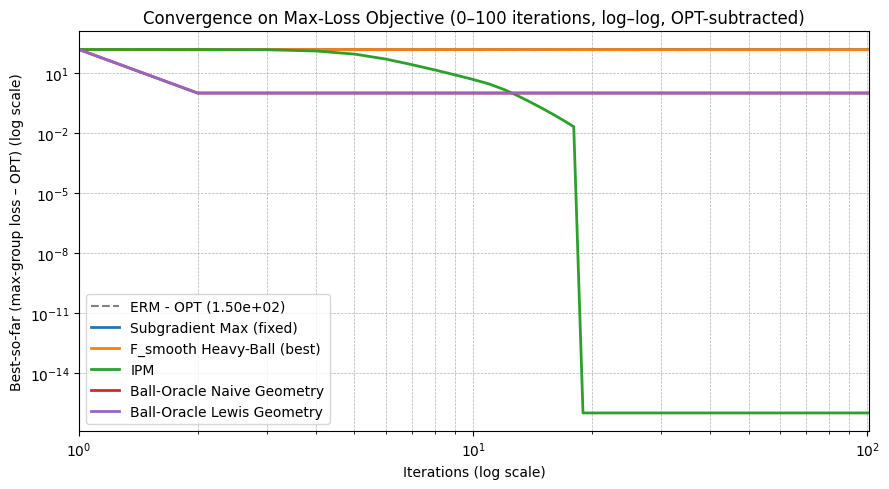

In [53]:
# ============================================================
# Block: Final Convergence Plot (0–100 its, log–log, OPT-subtracted)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

def pick_best_label(candidates, results_final):
    best_label = None
    best_val = float("inf")
    for lbl in candidates:
        if lbl in results_final:
            val = results_final[lbl]
            if np.isfinite(val) and val < best_val:
                best_val = val
                best_label = lbl
    return best_label

# Families consistent with logging from each block
subgrad_family = [
    "Subgradient Max (fixed)",
    "Subgradient Max (dim)",
    "Subgradient Max",
]

smooth_family = [
    "F_smooth GD (best)",
    "F_smooth Heavy-Ball (best)",
    "F_smooth Nesterov (best)",
]

ipm_family = ["IPM"]

naive_family = [
    "Ball-Oracle Naive Geometry",
    "Ball-Oracle Naive Geometry (anneal)",
]

lewis_family = [
    "Ball-Oracle Lewis Geometry",
    "Ball-Oracle Lewis (Newton)",
    "Ball-Oracle Lewis (Newton, anneal)",
]

selected_labels = []

best_subgrad = pick_best_label(subgrad_family, results_final)
if best_subgrad is not None:
    selected_labels.append(best_subgrad)

best_smooth = pick_best_label(smooth_family, results_final)
if best_smooth is not None:
    selected_labels.append(best_smooth)

best_ipm = pick_best_label(ipm_family, results_final)
if best_ipm is not None:
    selected_labels.append(best_ipm)

best_naive = pick_best_label(naive_family, results_final)
if best_naive is not None:
    selected_labels.append(best_naive)

best_lewis = pick_best_label(lewis_family, results_final)
if best_lewis is not None:
    selected_labels.append(best_lewis)

plt.figure(figsize=(9, 5))

# Retrieve OPT (subtract baseline)
F_opt = results_final.get("OPT", None)
if F_opt is not None and np.isfinite(F_opt):
    print(f"[Plot] Subtracting OPT = {F_opt:.6e}")
else:
    print("[Plot] No OPT found; plotting raw losses.")
    F_opt = 0.0  # fallback (no subtraction)

# ERM baseline (horizontal line)
erm_val = None
if "ERM" in results_final and np.isfinite(results_final["ERM"]):
    erm_val = results_final["ERM"]
elif "ERM baseline" in results_final and np.isfinite(results_final["ERM baseline"]):
    erm_val = results_final["ERM baseline"]

if erm_val is not None:
    y_val = max(erm_val - F_opt, 1e-16)
    plt.axhline(
        y=y_val,
        linestyle="--",
        linewidth=1.5,
        color="gray",
        label=f"ERM - OPT ({y_val:.2e})",
    )

# Plot selected curves (subtract OPT)
for label in selected_labels:
    data = results_curves.get(label)
    if not data:
        continue

    iters = np.asarray(data.get("iters", []), dtype=float)
    vals = np.asarray(data.get("best_values", []), dtype=float)
    if iters.size == 0 or vals.size == 0:
        continue

    mask = np.isfinite(iters) & np.isfinite(vals)
    iters = iters[mask]
    vals = vals[mask]
    if iters.size == 0:
        continue

    # Subtract OPT and clip to positive domain for log-scale
    vals_shifted = np.maximum(vals - F_opt, 1e-16)

    # Shift so t=0 → x=1 for log-scale
    x_plot = iters + 1.0

    marker = "o" if len(x_plot) <= 40 else None

    plt.plot(
        x_plot,
        vals_shifted,
        label=label,
        linewidth=2.0,
        marker=marker,
        markersize=4 if marker else 0,
    )

plt.xscale("log")
plt.yscale("log")
plt.xlim(left=1.0, right=101.0)
plt.xlabel("Iterations (log scale)")
plt.ylabel("Best-so-far (max-group loss – OPT) (log scale)")
plt.title("Convergence on Max-Loss Objective (0–100 iterations, log–log, OPT-subtracted)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[Time plot] Subtracting OPT = 3.409583e+03


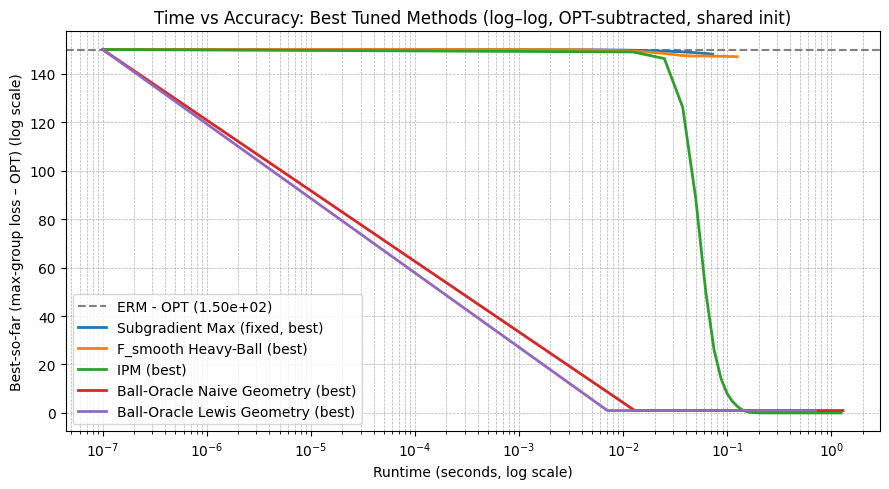

In [57]:
# ============================================================
# Block: Time vs Accuracy for Best Tuned Methods (log–log, OPT-subtracted)
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt

# Shared init so timing comparison is fair
x0_time = get_init(DEFAULT_WARM_START)

# ------------------ Helpers ------------------ #

def monotone_best(vals):
    vals = np.asarray(vals, float).copy()
    for i in range(1, len(vals)):
        if vals[i] > vals[i - 1]:
            vals[i] = vals[i - 1]
    return vals

def scaled_times(iters, total_runtime):
    iters = np.asarray(iters, float)
    if iters.size == 0:
        return np.array([])
    T_max = max(float(iters[-1]), 1.0)
    total = max(float(total_runtime), 1e-9)
    return (iters / T_max) * total

# ------------------ Timed runners ------------------ #

def timed_run_subgrad(A_groups, b_groups, x0, cfg, T=100):
    if cfg is None:
        print("[Time plot] No subgrad_cfg; skipping.")
        return None

    mode = cfg.get("mode", "fixed")
    start = time.perf_counter()

    if mode == "fixed":
        res = run_subgradient_max_fixed(
            A_groups, b_groups, x0,
            step=cfg["step"], T=T, verbose=False, record_curve=True,
        )
        label = "Subgradient Max (fixed, best)"
    else:
        res = run_subgradient_max_diminishing(
            A_groups, b_groups, x0,
            base_step=cfg["base_step"], T=T, verbose=False, record_curve=True,
        )
        label = "Subgradient Max (dim, best)"

    end = time.perf_counter()

    if res is None or res.get("iters") is None:
        print("[Time plot] Subgrad run failed.")
        return None

    times = scaled_times(res["iters"], end - start)
    vals = monotone_best(res["best_values"])
    return label, (times, vals)


def timed_run_smooth(A_groups, b_groups, x0, cfg, T=100):
    if cfg is None:
        print("[Time plot] No smooth_cfg; skipping.")
        return None

    var = cfg.get("variant", "gd")
    start = time.perf_counter()

    if var == "gd":
        res = run_smooth_gd(
            A_groups, b_groups, x0,
            beta=cfg["beta"], delta=cfg["delta"], step=cfg["step"],
            T=T, verbose=False, record_curve=True,
        )
        label = "F_smooth GD (best)"
    elif var == "heavy":
        res = run_smooth_heavy_ball(
            A_groups, b_groups, x0,
            beta=cfg["beta"], delta=cfg["delta"], step=cfg["step"],
            momentum=cfg["momentum"], T=T, verbose=False, record_curve=True,
        )
        label = "F_smooth Heavy-Ball (best)"
    else:  # "nesterov"
        res = run_smooth_nesterov(
            A_groups, b_groups, x0,
            beta=cfg["beta"], delta=cfg["delta"], step=cfg["step"],
            momentum=cfg["momentum"], T=T, verbose=False, record_curve=True,
        )
        label = "F_smooth Nesterov (best)"

    end = time.perf_counter()

    if res is None or res.get("iters") is None:
        print(f"[Time plot] F_smooth {var} run failed.")
        return None

    times = scaled_times(res["iters"], end - start)
    vals = monotone_best(res["best_values"])
    return label, (times, vals)


def timed_run_ipm(A_groups, b_groups, x0, cfg, max_steps=100):
    if cfg is None:
        print("[Time plot] No ipm_cfg; skipping.")
        return None

    start = time.perf_counter()
    res = run_ipm(
        A_groups, b_groups, x0,
        mu0=cfg["mu0"], tau=cfg["tau"], inner_iters=cfg["inner_iters"],
        max_newton_steps=max_steps, verbose=False, record_curve=True,
    )
    end = time.perf_counter()

    if res is None or res.get("iters") is None:
        print("[Time plot] IPM run failed.")
        return None

    times = scaled_times(res["iters"], end - start)
    vals = monotone_best(res["best_values"])
    return "IPM (best)", (times, vals)


def timed_run_naive(A_groups, b_groups, x0, cfg, max_outer=100):
    if cfg is None:
        print("[Time plot] No naive_cfg; skipping.")
        return None
    if "run_ball_oracle_naive" not in globals():
        print("[Time plot] run_ball_oracle_naive not defined; skipping.")
        return None

    start = time.perf_counter()
    res = run_ball_oracle_naive(
        A_groups, b_groups, x0,
        beta=cfg["beta"], delta=cfg.get("delta", 0.0),
        R0=cfg["R0"], n_outer=cfg.get("n_outer", max_outer),
        R_decay=cfg.get("R_decay", 1.0),
        max_newton_steps=cfg.get("max_newton_steps", 50),
        verbose=False, record_curve=True,
    )
    end = time.perf_counter()

    if res is None or res.get("iters") is None:
        print("[Time plot] Ball-Oracle Naive run failed.")
        return None

    iters = np.asarray(res["iters"], float)
    vals = monotone_best(res["best_values"])
    times = scaled_times(iters, end - start)
    return "Ball-Oracle Naive Geometry (best)", (times, vals)


def timed_run_lewis(A_groups, b_groups, x0, cfg, L, max_outer=100):
    if cfg is None:
        print("[Time plot] No lewis_cfg; skipping.")
        return None
    if "run_ball_oracle_lewis" not in globals():
        print("[Time plot] run_ball_oracle_lewis not defined; skipping.")
        return None

    start = time.perf_counter()
    res = run_ball_oracle_lewis(
        A_groups, b_groups, x0, L=L,
        beta=cfg["beta"], delta=cfg.get("delta", 0.0),
        R0=cfg["R0"], n_outer=cfg.get("n_outer", max_outer),
        R_decay=cfg.get("R_decay", 1.0),
        max_newton_steps=cfg.get("max_newton_steps", 50),
        verbose=False, record_curve=True,
    )
    end = time.perf_counter()

    if res is None or res.get("iters") is None:
        print("[Time plot] Ball-Oracle Lewis run failed.")
        return None

    iters = np.asarray(res["iters"], float)
    vals = monotone_best(res["best_values"])
    times = scaled_times(iters, end - start)
    return "Ball-Oracle Lewis Geometry (best)", (times, vals)

# ------------------ Collect curves ------------------ #

time_curves = {}

if "subgrad_cfg" in globals():
    out = timed_run_subgrad(A_groups, b_groups, x0_time, subgrad_cfg, T=100)
    if out is not None:
        label, curve = out
        time_curves[label] = curve

if "smooth_cfg" in globals():
    out = timed_run_smooth(A_groups, b_groups, x0_time, smooth_cfg, T=100)
    if out is not None:
        label, curve = out
        time_curves[label] = curve

if "ipm_cfg" in globals():
    out = timed_run_ipm(A_groups, b_groups, x0_time, ipm_cfg, max_steps=100)
    if out is not None:
        label, curve = out
        time_curves[label] = curve

if "naive_cfg" in globals():
    out = timed_run_naive(A_groups, b_groups, x0_time, naive_cfg, max_outer=100)
    if out is not None:
        label, curve = out
        time_curves[label] = curve

if "lewis_cfg" in globals() and "L_lewis" in globals():
    out = timed_run_lewis(A_groups, b_groups, x0_time, lewis_cfg, L_lewis, max_outer=100)
    if out is not None:
        label, curve = out
        time_curves[label] = curve

# ------------------ Plot (log–log, OPT-subtracted) ------------------ #

plt.figure(figsize=(9, 5))

F_opt = results_final.get("OPT", None)
if F_opt is not None and np.isfinite(F_opt):
    print(f"[Time plot] Subtracting OPT = {F_opt:.6e}")
else:
    print("[Time plot] No OPT in results_final; plotting raw losses.")
    F_opt = 0.0

erm_val = None
if "ERM" in results_final and np.isfinite(results_final["ERM"]):
    erm_val = results_final["ERM"]
elif "ERM baseline" in results_final and np.isfinite(results_final["ERM baseline"]):
    erm_val = results_final["ERM baseline"]

if erm_val is not None:
    gap = max(erm_val - F_opt, 1e-16)
    plt.axhline(
        y=gap,
        linestyle="--",
        linewidth=1.5,
        color="gray",
        label=f"ERM - OPT ({gap:.2e})",
    )

for label, (times, vals) in time_curves.items():
    times = np.asarray(times, float)
    vals = np.asarray(vals, float)
    mask = np.isfinite(times) & np.isfinite(vals)
    times, vals = times[mask], vals[mask]
    if times.size == 0:
        continue

    gaps = np.maximum(vals - F_opt, 1e-16)
    times = np.maximum(times, 1e-7)

    marker = "o" if len(times) <= 40 else None
    plt.plot(
        times, gaps,
        label=label, linewidth=2.0,
        marker=marker, markersize=4 if marker else 0,
    )

plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Runtime (seconds, log scale)")
plt.ylabel("Best-so-far (max-group loss – OPT) (log scale)")
plt.title("Time vs Accuracy: Best Tuned Methods (log–log, OPT-subtracted, shared init)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()